In [1]:
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os
from scipy import interpolate
from models import *
from IPython import display

In [257]:
md0=load_model(outdir='/noshear/')

stellar_params: {'Ms': 1.0, 'Rs': 2.0, 'Ts': 4000.0, 'accrate': 1e-07, 'f': 0.01}
disk_params: {'Mdisk': 0.010499999999999999, 'Mfrac': [0.005, 0.005], 'R0': [1, 1], 'Rout': [100, 50], 'H0': [1, 0.3], 'p': [-1, -1], 'fi': [0.25, 0.25], 'Rdisk': [105, 105]}
envelope_params: {'Min': 3e-06, 'Rc': 105, 'rho_amb': 1e-25, 'rho_0': 3e-22, 'theta_min': 15, 'exf': 0.25, 'Rmax': 15000.0, 'd2g': 0.01, 'shock': True}
grid_params: {'N': [400, 90, 90], 'min': [2, 0.19634954084936207, 0], 'max': [400, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 3.1518, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': 3.5}
RT_params: {'cr_model': 'ssx', 'zetacr': 1.3e-17, 'LX': 1e+30, 'G0': 1, 'viscous_heating': True}
directory exists - will overwrite current model if you write to it!
Loading from model directory:/Users/aleksandra/Desktop/wedgeford/noshear/
Reading amr_grid.inp
Reading wavelength_micron.inp


In [258]:
data_path = '/Users/aleksandra/Desktop/new_runs/'

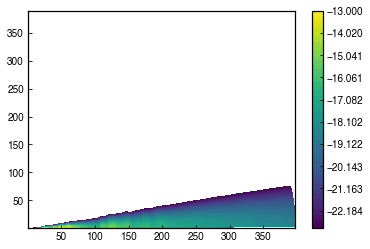

In [283]:
def disk_from_fargo(output,simdir,snapshot,fluid=0):
    model = output.m
    disk = fargo_disk(simdir,Mstar=model.star['Ms'])
    R,THETA,PHI = model.make_grid()
    X_C = R*np.sin(THETA)*np.cos(PHI)
    Y_C = R*np.sin(THETA)*np.sin(PHI)
    Z_C = R*np.cos(THETA)
    R_CYL = np.sqrt(X_C**2 + Y_C**2)
    sigma_2d = disk.get(time=snapshot,prop='sigma')
    x_disk, y_disk = disk.xy()
    if fluid < 2: #
        sigma_2d_scaled = sigma_2d
        if fluid == 1:
            sigma_2d_scaled *= model.disk['Mfrac'][0]
    else:
        a1 = disk.dust['dust1']*sigma_2d/((pi/2.)*model.dust['rho_si'])
        a2 = disk.dust['dust2']*sigma_2d/((pi/2.)*model.dust['rho_si'])
        sigma_2d_1 = disk.get(time=snapshot,prop='sigma',fluid='dust1')
        sigma_2d_2 = disk.get(time=snapshot,prop='sigma',fluid='dust2')
        sigma_2d_tot = sigma_2d_1+sigma_2d_2
        amin = model.dust['amin'][-1]*1e-4 #micron to cm
        amax = model.dust['amax'][-1]*1e-4
        powerlaw = model.dust['apow']
        amid = (np.log10(a1) + np.log10(a2))/2.
        mmid = np.log10(sigma_2d_2*((10**(amid)/a2)**(-(powerlaw-3))))
        a0 = np.log10(amax)
        m0 = mmid + (powerlaw - 3.)*(amid - a0)
        sigma_2d_scaled = (10**m0)*((10**a0)**(powerlaw-3))*(amax**(-(powerlaw-4)) - amin**(-(powerlaw-4)))/(-(powerlaw-4))
    sig_xy = interpolate.griddata((x_disk.flatten(),y_disk.flatten()), sigma_2d_scaled.T.flatten(), (X_C[-1,:,:],Y_C[-1,:,:]), method='linear',fill_value=0,rescale=True)
    hmid = model.H(R_CYL,fluid=fluid)
    rho_vol = np.clip(np.expand_dims(sig_xy,axis=0)/(sqrt(pi*2.)*hmid*AU),a_min=model.env['rho_amb'],a_max=None)*np.exp(-0.5*(Z_C/hmid)**2)
    return rho_vol
disk_from_fargo(md0,data_path+'gmaur_0005/',20,fluid=2)
    

In [10]:
def insert_hydrodust(output,small_hydro,large_hydro):
    model = output.m
    if os.getcwd() != model.outdir:
            os.chdir(model.outdir)
    output.data.readDustDens() #self.data.rhodust is now loaded in
    small_dust_all0 = output.data.rhodust[:,:,:,0].swapaxes(0,1)
    large_dust_all0 = output.data.rhodust[:,:,:,1].swapaxes(0,1)
    small_dust_disk0 = model.rho_disk(fluid=1)
    large_dust_disk0 = model.rho_disk(fluid=2)
    small_dust = small_dust_all0 - small_dust_disk0 + small_hydro
    large_dust = large_dust_all0 - large_dust_disk0 + large_hydro
    Nr = np.prod(np.array(model.grid['N']))
    with open(model.outdir+'dust_density.inp','w+') as f:
        f.write('1\n')                   # Format number
        f.write('%d\n'%(Nr))             # Number of cells
        f.write('2\n')                   # Number of dust species
        for dust in [small_dust,large_dust]:
            data = dust.swapaxes(0,1).ravel(order='F') # radmc assumes 'ij' indexing for some reason, Create a 1-D view, fortran-style indexing
            data.tofile(f, sep='\n', format="%13.6e")
            f.write('\n')
    f.close()
    